## Matting model

In [5]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from data_generator import *
from network import network_big

def convert_checkpoint_into_tflite(h5_path=None,
                                   output_path=None,
                                   android=True):

    input_size = (256, 256)
    
    if android:
        model = network_big(input_size + (4,), android=True, train=False)
        
    else:
        model = network_big(input_size + (3,), android=False, train=False)
        
    # model 명 과 상세사항 정리해두기 
    model.load_weights(h5_path, by_name=False)
    
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    
    tflite_model = converter.convert()

    input_names = [node.op.name for node in model.inputs]
    output_names = [node.op.name for node in model.outputs]
    print(model.inputs)
    print(input_names)
    print(output_names)
    
    with open(output_path, "wb") as f:
        f.write(tflite_model)
        
    print("tflite successfully built")
    
    return model

In [6]:
model = convert_checkpoint_into_tflite(h5_path="./trained_models/widerScale/2862-0.05.h5",
                                       output_path="./tflite/wider_scale_2862-0.05.tflite", 
                                       android=True)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /var/folders/zz/k00bvfms68v11x9rl72ymn100000gn/T/tmpz0jry821/assets
[<tf.Tensor 'input_1:0' shape=(None, 256, 256, 4) dtype=float32>]
['input_1']
['output/Sigmoid']
tflite successfully built


## Model output test

In [7]:
import numpy as np 
import cv2
# import matplotlib.pyplot as plt

img = cv2.imread("./dataset/selfie/training/00694.png", cv2.IMREAD_COLOR)
# img = cv2.imread("../../IMG_3764.JPG", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
img = np.concatenate([img, np.ones((256,256,1))], axis=-1)[np.newaxis,:,:,:] / 255.
# img = img.astype(np.float32)
# img = img[np.newaxis,:,:,:] / 255.

mask = cv2.imread("./dataset/selfie/training/00694_matte.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))

pred = model.predict(img)

In [8]:
def get_edge(mask):

    edge = cv2.Canny(mask, 50, 100)
    k = np.int((mask[mask > 50].shape[0] / (mask.shape[0] * mask.shape[1])) * 30)
    if k < 5:
        k = 5
    k = 18
    ksize = (k, k)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)

    dil = cv2.dilate(edge, kernel)

    return dil
bound = get_edge(mask)

In [9]:
cv2.threshold(pred.squeeze(0).squeeze(-1), 0.5, 1, cv2.THRESH_BINARY)

(0.5,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]], dtype=float32))

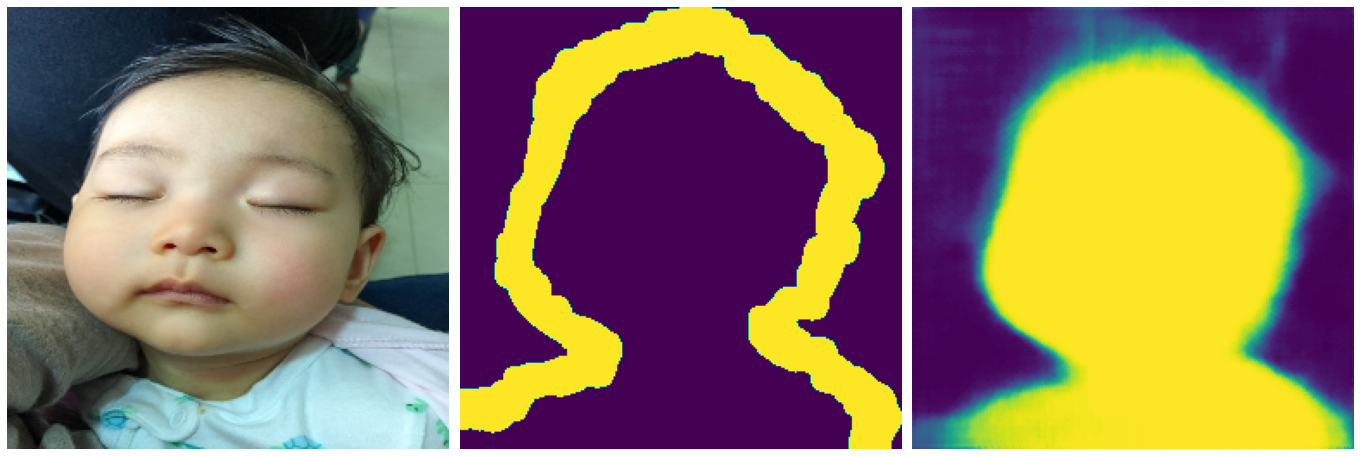

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(19,7))
plt.subplot(131)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(132)
plt.imshow(bound )
plt.axis("off")

plt.subplot(133)
plt.imshow(pred.squeeze(0).squeeze(-1))
plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
mask_ = tf.constant(cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)[1]/ 255.)
# pred_ = tf.constant(cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)[1] / 255.)
pred_ = tf.constant(pred.squeeze(0).squeeze(-1))

In [12]:
mask_ = tf.reshape(mask_, (1, 256, 256, 1))
pred_ = tf.reshape(pred_, (1, 256, 256, 1))